In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys
sys.path.append('../../code/')
sys.path.append('/Users/ssulheim/git/mwf_gems/code/python')
import ng_utils
import leakage
import leakage_reframed
import reframed
import scipy
import statsmodels.api as sm
import seaborn as sns

# Ecoli

In [28]:
exometabolites_folder = Path("../../data/e_coli/")
organism = 'e_coli'
fn_OD = exometabolites_folder / "{0}_OD.csv".format(organism)

In [29]:
gDW_per_OD = 0.32

In [30]:
concentrations, concentrations_std = leakage.get_concentrations(exometabolites_folder, 'e_coli')

In [31]:
fn_glucose = exometabolites_folder / "{0}_glucose.csv".format(organism)
glucose_df = pd.read_csv(fn_glucose)

## Remove outliers

In [32]:
concentrations.loc[1, 'FUM'] = np.nan

In [33]:
df_OD = pd.read_csv(fn_OD, index_col=0)
# Assume that OD std is not correlated with OD (see plot below for support of this assumption)
df_OD.fillna(df_OD['OD std'].mean())

,OD mean,OD std
Time,,
0,0.500,0.116168
1,0.514,0.116168
2,0.608,0.116168
3,0.817,0.116168
4,1.595,0.049497
5,2.295,0.190919
6,5.085,0.035355
7,8.765,0.106066
8,13.300,0.056569


## No clear correlation between OD and OD std

Text(0, 0.5, 'std(OD600)')

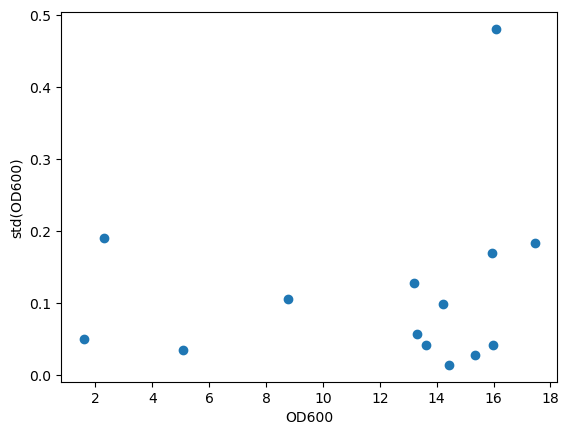

In [34]:
plt.scatter(df_OD['OD mean'], df_OD['OD std'])
plt.xlabel('OD600')
plt.ylabel('std(OD600)')

Text(0, 0.5, 'ln(OD600)')

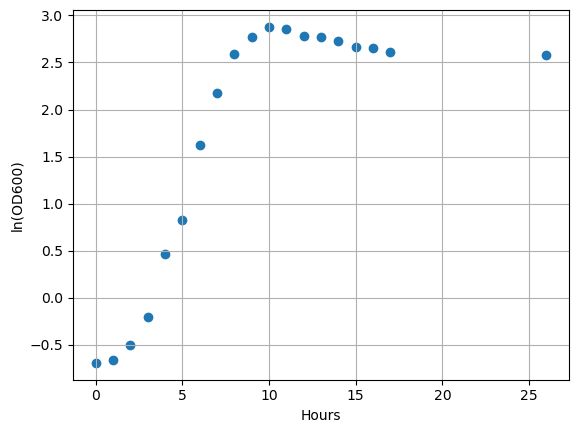

In [35]:
plt.scatter(df_OD.index, np.log(df_OD['OD mean']))
plt.grid()
plt.xlabel('Hours')
plt.ylabel('ln(OD600)')

Text(0, 0.5, 'ln(OD600)')

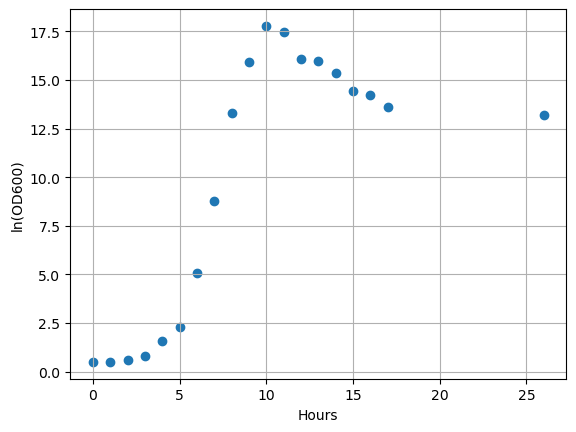

In [36]:
plt.scatter(df_OD.index, df_OD['OD mean'])
plt.grid()
plt.xlabel('Hours')
plt.ylabel('ln(OD600)')

## Mapping

In [37]:
mapping_df = pd.read_csv('../../data/id_mapping.csv', index_col=0)
# mapping_df.index = [x.strip('\t').replace(" MS", "") for x in mapping_df.index]
met_abrv_to_id = mapping_df['Ecoli metabolite'].to_dict()
met_abrv_to_name = mapping_df['Metabolite name'].to_dict()


# Estimate rates

In [38]:
df_OD

,OD mean,OD std
Time,,
0,0.500,NaN
1,0.514,NaN
2,0.608,NaN
3,0.817,NaN
4,1.595,0.049497
5,2.295,0.190919
6,5.085,0.035355
7,8.765,0.106066
8,13.300,0.056569


## Simpson integration

In [39]:
xt = np.zeros(len(df_OD)-1)
for i in range(1, len(df_OD)-1):
    xt[i] = scipy.integrate.simpson(df_OD.loc[:i, 'OD mean'].values, x = df_OD.index[:i+1])
    # xt[i] = np.trapz(df_OD.loc[:i, 'OD mean'], dx=1)
    print(i, df_OD.loc[i, 'OD mean'], xt[i]*gDW_per_OD)

1 0.514 0.16224
2 0.608 0.3374933333333333
3 0.817 0.5624266666666666
4 1.595 0.9210666666666666
5 2.295 1.5455466666666666
6 5.085 2.6127999999999996
7 8.765 4.805066666666667
8 13.3 8.313600000000001
9 15.94 13.042533333333333
10 17.78 18.429866666666666
11 17.45 24.124533333333336
12 16.1 29.48906666666667
13 15.99 34.5904
14 15.34 39.66506666666667
15 14.43 44.4352
16 14.21 48.973866666666666
17 13.61 53.435199999999995


## Trapezoidial rule

In [40]:
# xt = np.zeros(len(df_OD)-1)
# for i in range(1, len(df_OD)-1):
    
#     xt[i] = np.trapz(df_OD.loc[:i, 'OD mean'], dx=1)
#     print(i, df_OD.loc[i, 'OD mean'], xt[i]*gDW_per_OD)

In [41]:
x = pd.Series(xt*gDW_per_OD, index = df_OD.index[:-1])


In [42]:

df_auc = pd.DataFrame(x, columns = ['AUC'])
df_auc['OD'] = df_OD.loc[:18, 'OD mean'].values
df_auc.to_csv('auc_ecoli.csv')

In [43]:
concentrations.to_csv('conc_ecoli.csv')

Text(0, 0.5, 'Cumulative gDW')

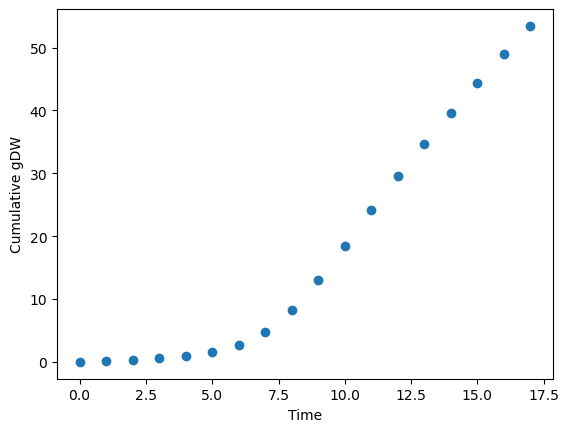

In [44]:
plt.scatter(df_OD.index[:-1], x)
plt.xlabel('Time')
plt.ylabel('Cumulative gDW')

# Fit with custom limits

In [45]:
specific_limits = {
    'G6P': (1, 10),
    'F6P': (1, 10),
    'FBP': (7, 10),
    'DHAP': (1, 10),
    'GA3P': (1, 10),
    '23PG': (1, 10),
    'PEP': (3, 10),
    'R5P': (1, 10),
    'RU5P+X5P': (3, 10),
    'E4P': (6, 10),
    'CIT': (1, 10),
    'ACN': (1, 10),
    'ICIT': (1, 10),
    'OAS': (1, 7),
    'GLU': (1, 10),
    'SER': (1, 10),
    'ASP': (1, 10),
    'THR': (1, 10),
    'HOM': (1, 10),
    'TYR': (1, 10),
    'GLY': (1, 10),
    'PRO': (1, 8),
    'ALA': (1, 9),
    'MET': (1, 9),
    'VAL': (1, 9),
    'PHE': (1, 10),
    'ILEU': (1, 10),
    'LEU': (1, 10),
    'TRP': (1, 6),
    'HIS': (1, 6),
    'ARG': (1, 7),
    'PYR': (1, 8),
    'ORO': (1, 8),
    'FUM': (3, 8),
    'URA': (1, 10),
    'AKG': (7, 10),
    'ACT': (1, 8)
    # 'OAS':5,
    # 'TYR':7,
    # 'PRO':6,
}

In [46]:
# X = sm.add_constant(x[idx])
# mod = sm.OLS(conc[idx],X)
# fii = mod.fit()
# tbl = fii.summary2().tables[1].T[0]
# tbl['Metabolite'] = conc.name
# pd.DataFrame([tbl])
# p_values = fii.summary2().tables[1]['P>|t|']

R-squared: 0.956918
R-squared: 0.969737
R-squared: 0.963665
R-squared: 0.990922
R-squared: 0.991909
R-squared: 0.990963
R-squared: 0.962801
R-squared: 0.966783
R-squared: 0.986262
R-squared: 0.973586
R-squared: 0.958805
R-squared: 0.948308
R-squared: 0.990536
R-squared: 0.883066
R-squared: 0.000150
R-squared: 0.738294
R-squared: 0.981425
R-squared: 0.968830
R-squared: 0.984045
R-squared: 0.962918
R-squared: 0.328396
R-squared: 0.875327
R-squared: 0.913987
R-squared: 0.968013
R-squared: 0.976391
R-squared: 0.943323
R-squared: 0.985073
R-squared: 0.975334
R-squared: 0.981951
R-squared: 0.834846
R-squared: 0.946672
R-squared: 0.987879
R-squared: 0.972809
R-squared: 0.909347
R-squared: 0.736555
R-squared: 0.863027
R-squared: 0.918369


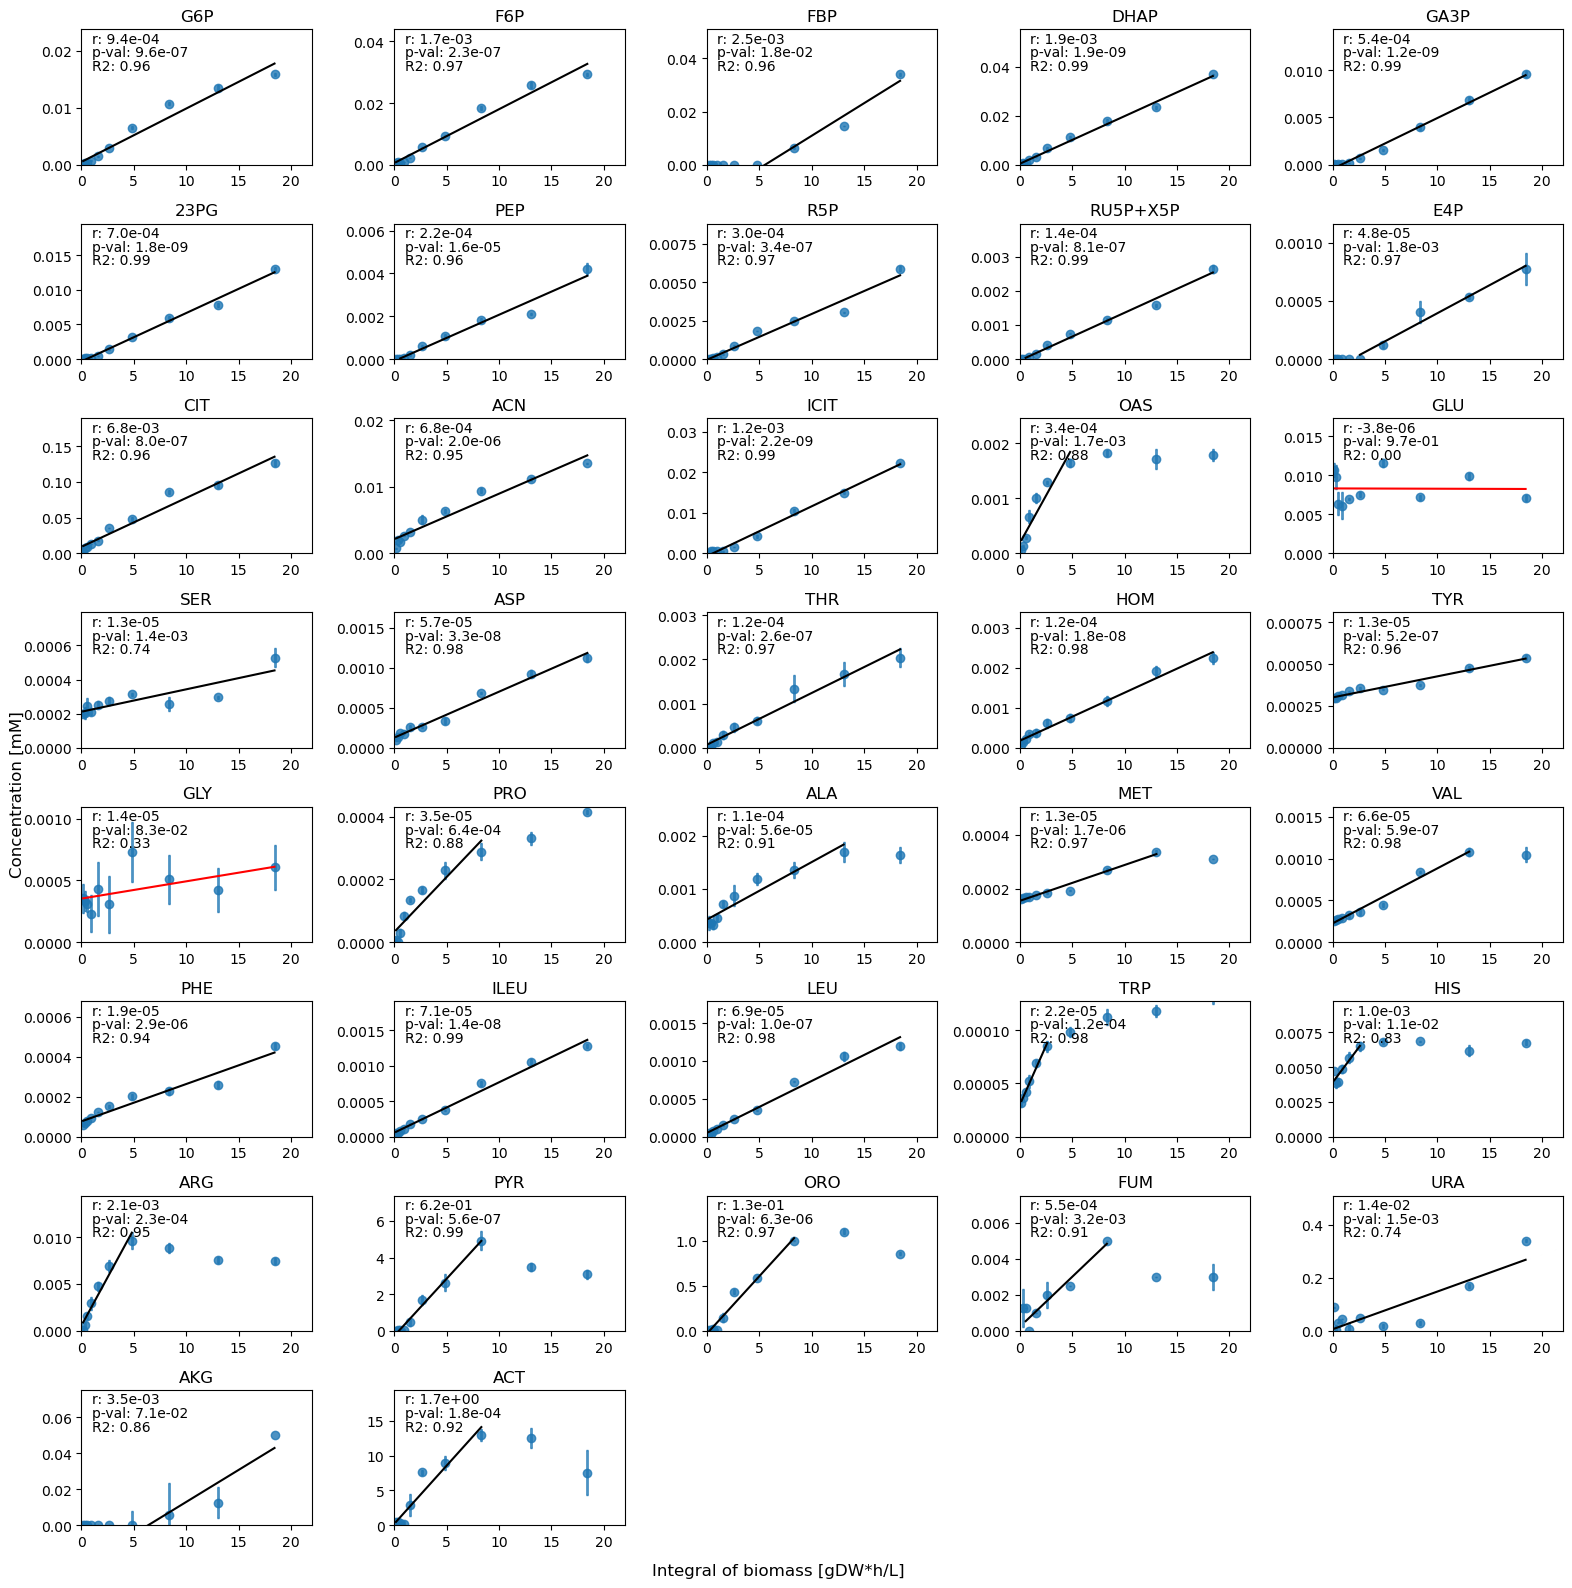

In [47]:
rate_dict_m = {}
fig, axes = plt.subplots(8,5, figsize = (16, 16), sharex = False)
axes = axes.flatten()
fun = lambda x, a ,b: x*a+b
data_list = []
for i,c in enumerate(concentrations.columns):
    # print(c)
    conc = concentrations[c][:-1]*1e-3 # Convert from uM to mM #
    conc_std = concentrations_std[c][:-1]*1e-3
    lim = specific_limits[c]
    idx = ((concentrations.index >= lim[0]) & (concentrations.index <= lim[1]))[:-1]
    rate_conc = conc[idx]
    if np.sum(rate_conc == 0) > 1:
        print(c, 'More than 1 zero')
    # conc[conc==0] = np.nan
    res = scipy.stats.linregress(x[idx], conc[idx])
    print(f"R-squared: {res.rvalue**2:.6f}")
    r2 = res.rvalue**2
    
    # fit, cov, _,_,_ = scipy.optimize.curve_fit(fun, x[idx],
    #                                            conc[idx], full_output=True)
    # rate = fit[0]
    # std_err = np.sqrt(np.diag(cov))[0]
    # t_score = fit[0]/std_err
    # n_df = np.sum(idx)-2
    # p_val = scipy.stats.t.sf(t_score, df = n_df)*2 # *2 is to get two-sided
    # data = [rate, std_err, t_score, n_df, p_val, c, p_val < 0.05]
    data = [res.slope, res.stderr,res.pvalue, c, res.pvalue < 0.05, r2]
    data_list.append(data)
    # rate_dict_m[c] = fit[0]
    # print(fit)
    x_fit = np.linspace(x[idx].min(), x[idx].max(), 3)
    y_fit = fun(x_fit, res.slope, res.intercept)
    ax = axes[i]
    # ax.scatter(x, conc)
    # ax.scatter(x, conc)
    ax.errorbar(x, conc, yerr = conc_std, fmt='o',color='C0',capthick=1,elinewidth=2,capsize=1, zorder = 0, alpha = 0.8)
    if r2 > 0.5:
        ax.plot(x_fit, y_fit, 'k')
    else:
        ax.plot(x_fit, y_fit, 'r')
    ax.set_title(c, )
    ax.set_xlim(0, 22)
    y_max = np.max(conc[idx])*1.5
    ax.set_ylim(0, y_max)
    ax.annotate(f'r: {res.slope:.1e}', (1, y_max*0.9))
    ax.annotate(f'p-val: {res.pvalue:.1e}', (1, y_max*0.8))
    ax.annotate(f'R2: {r2:.2f}', (1, y_max*0.7))
    i +=1
    # print(i)

while i<(8*5):
    axes[i].set_visible(False)
    i+=1

fig.supxlabel('Integral of biomass [gDW*h/L]')
fig.supylabel('Concentration [mM]')

plt.tight_layout()
plt.savefig('ecoli_fitted_rates_manual_limits.png', dpi = 400)
plt.show()

In [48]:
rate_data = pd.DataFrame(data_list, columns = ['Rate [mmol/gDW/h]', 'Std.Err [mmol/gDW/h]', 'p-val', 'Metabolite abbrv.', 'Significance', 'R2'])

In [49]:

rate_data

,Rate [mmol/gDW/h],Std.Err [mmol/gDW/h],p-val,Metabolite abbrv.,Significance,R2
0,0.000938,7.040245e-05,9.586334e-07,G6P,True,0.956918
1,0.001747,1.090889e-04,2.321812e-07,F6P,True,0.969737
2,0.002451,3.365155e-04,1.833552e-02,FBP,True,0.963665
3,0.001946,6.586015e-05,1.863626e-09,DHAP,True,0.990922
4,0.000539,1.721183e-05,1.175813e-09,GA3P,True,0.991909
5,0.000699,2.360003e-05,1.830542e-09,23PG,True,0.990963
6,0.000216,1.733861e-05,1.631595e-05,PEP,True,0.962801
7,0.000298,1.955910e-05,3.374006e-07,R5P,True,0.966783
8,0.000140,6.755605e-06,8.145372e-07,RU5P+X5P,True,0.986262
9,0.000048,4.590249e-06,1.836571e-03,E4P,True,0.973586


# Subset for figure 1

In [50]:
x[10]

18.429866666666666

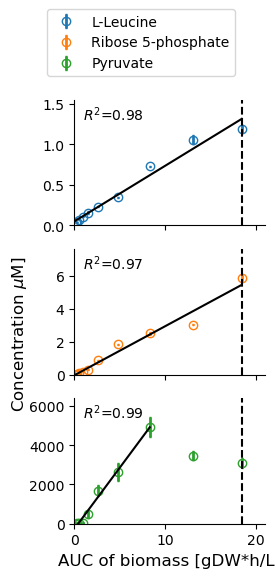

In [51]:
m_abbr_to_name = {
    'LEU': 'L-Leucine',
    'R5P': 'Ribose 5-phosphate',
    'PYR': 'Pyruvate'
}
fig, axes = plt.subplots(3,1, figsize = (3,5), sharex=True)
for i, (c, name) in enumerate(m_abbr_to_name.items()):
    conc = concentrations[c][:-1]
    conc_std = concentrations_std[c][:-1]
    lim = specific_limits[c]
    idx = ((concentrations.index >= lim[0]) & (concentrations.index <= lim[1]))[:-1]
    rate_conc = conc[idx]
    axes[i].errorbar(x, conc, yerr = conc_std, 
                     fmt='o',color=f'C{i}',capthick=1,elinewidth=2,capsize=1,
                     zorder = 0, label = name, markeredgecolor = f'C{i}', markerfacecolor = 'none')#alpha = 0.8
    res = scipy.stats.linregress(x[idx], conc[idx])
    x_fit = np.linspace(x[idx].min(), x[idx].max(), 3)
    y_fit = fun(x_fit, res.slope, res.intercept)
    
    # axes[i].set_title(name, y = 0.8, size = 10)
    axes[i].set_xlim(0, 21)
    y_max = np.max(conc[idx])*1.3
    axes[i].set_ylim(0, y_max)
    axes[i].plot(x_fit, y_fit, 'k')
    axes[i].axvline(x[10], c = 'k', ls = '--')
    
    # axes[i].annotate(f'r: {res.slope:.1e}', (1, y_max*0.9))
    # axes[i].annotate(f'p-val: {res.pvalue:.1e}', (1, y_max*0.8))
    r2 = res.rvalue**2
    axes[i].annotate(f'$R^2$={r2:.2f}', (1, y_max*0.84))
axes[i].set_xlabel('AUC of biomass [gDW*h/L]', size = 12)#, y = 0.1)
fig.supylabel(r'Concentration $\mu$M]', x = 0.1)
plt.figlegend(loc = "lower left", bbox_to_anchor = (0.2, 1))

plt.tight_layout()
sns.despine()
# plt.subplots_adjust(bottom = 0.2, left = 0.2)
plt.savefig('fitted_rates_for_fig1.pdf', bbox_inches='tight')


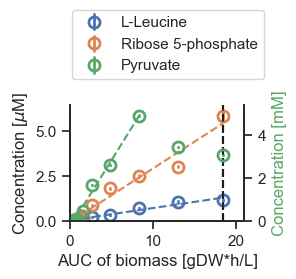

In [52]:
m_abbr_to_name = {
    'LEU': 'L-Leucine',
    'R5P': 'Ribose 5-phosphate',
    'PYR': 'Pyruvate'
}
sns.set(font_scale = 1, style = 'ticks')
fig, ax1 = plt.subplots(1,1, figsize = (3,2), sharex=True)
ax2 = ax1.twinx()
for i, (c, name) in enumerate(m_abbr_to_name.items()):
    conc = concentrations[c][:-1]
    conc_std = concentrations_std[c][:-1]
    lim = specific_limits[c]
    idx = ((concentrations.index >= lim[0]) & (concentrations.index <= lim[1]))[:-1]
    rate_conc = conc[idx]
    if i < 2:
        ax = ax1
    else:
        ax = ax2

    if name == 'Pyruvate':
        # Plot in mM
        conc = conc*1e-3
        conc_std = conc*1e-3
    ax.errorbar(x, conc, yerr = conc_std, 
                     fmt='o',color=f'C{i}',capthick=1,elinewidth=2,capsize=1,
                     zorder = 0, label = name, markeredgecolor = f'C{i}', markerfacecolor = 'none', markersize = 8, markeredgewidth = 2)#alpha = 0.8
    res = scipy.stats.linregress(x[idx], conc[idx])
    x_fit = np.linspace(x[idx].min(), x[idx].max(), 3)
    y_fit = fun(x_fit, res.slope, res.intercept)
    
    # axes[i].set_title(name, y = 0.8, size = 10)
    ax.set_xlim(0, 21)
    y_max = np.max(conc[idx])*1.1
    ax.set_ylim(0, y_max)
    ax.plot(x_fit, y_fit, c = f'C{i}', ls = '--')
    ax.axvline(x[10], c = 'k', ls = '--', zorder = 0, alpha = 0.8)
    
    # axes[i].annotate(f'r: {res.slope:.1e}', (1, y_max*0.9))
    # axes[i].annotate(f'p-val: {res.pvalue:.1e}', (1, y_max*0.8))
    r2 = res.rvalue**2
    axes[i].annotate(f'$R^2$={r2:.2f}', (1, y_max*0.84))
ax1.set_xlabel('AUC of biomass [gDW*h/L]', size = 12)#, y = 0.1)
ax1.set_ylabel(r'Concentration [$\mu$M]', size = 12)
ax2.set_ylabel(r'Concentration [mM]', size = 12, c = 'C2')
plt.figlegend(loc = "lower left", bbox_to_anchor = (0.2, 1))

plt.tight_layout()
sns.despine(top = True, right = False)
# plt.subplots_adjust(bottom = 0.2, left = 0.2)
plt.savefig('fitted_rates_for_fig1_1_panel.pdf', bbox_inches='tight')


In [53]:
rate_data #res.stderr,res.pvalue, c, p_val < 0.05, r2

,Rate [mmol/gDW/h],Std.Err [mmol/gDW/h],p-val,Metabolite abbrv.,Significance,R2
0,0.000938,7.040245e-05,9.586334e-07,G6P,True,0.956918
1,0.001747,1.090889e-04,2.321812e-07,F6P,True,0.969737
2,0.002451,3.365155e-04,1.833552e-02,FBP,True,0.963665
3,0.001946,6.586015e-05,1.863626e-09,DHAP,True,0.990922
4,0.000539,1.721183e-05,1.175813e-09,GA3P,True,0.991909
5,0.000699,2.360003e-05,1.830542e-09,23PG,True,0.990963
6,0.000216,1.733861e-05,1.631595e-05,PEP,True,0.962801
7,0.000298,1.955910e-05,3.374006e-07,R5P,True,0.966783
8,0.000140,6.755605e-06,8.145372e-07,RU5P+X5P,True,0.986262
9,0.000048,4.590249e-06,1.836571e-03,E4P,True,0.973586


## Fit with automatic limits

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


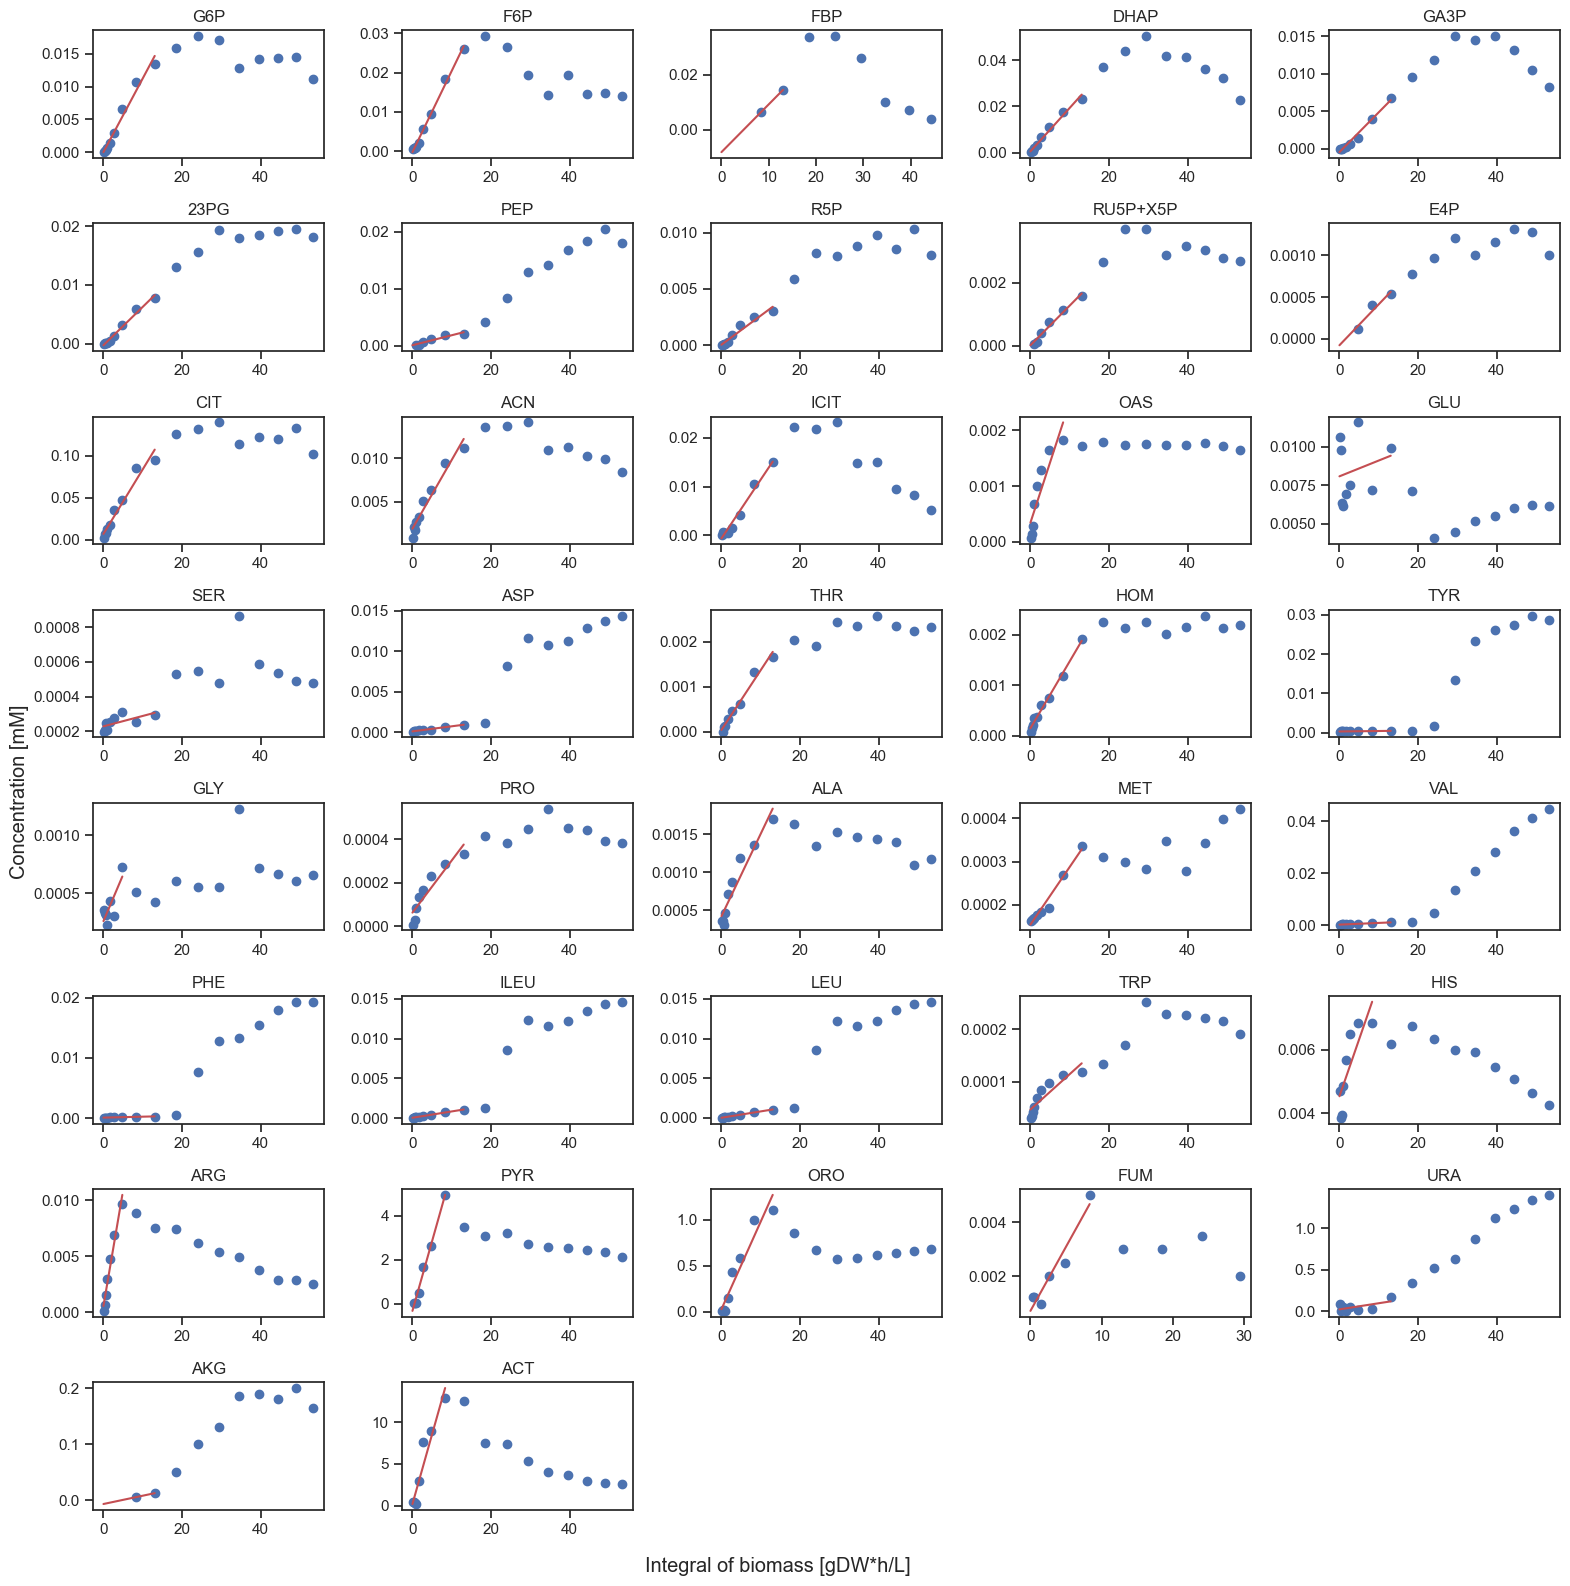

In [54]:
rate_dict = {}
fig, axes = plt.subplots(8,5, figsize = (16, 16), sharex = False)
axes = axes.flatten()
fun = lambda x, a ,b: x*a+b
for i,c in enumerate(concentrations.columns):
    conc = concentrations[c][:-1]*1e-3
    conc[conc==0] = np.nan
    nan_idx = ~np.isnan(conc)
    time_idx = x.index < 10
    if np.sum(nan_idx&time_idx) == 1:
        conc[0] = 0
        nan_idx[0] = True
        
    # print(conc[nan_idx&time_idx])
    rate_conc = conc[nan_idx&time_idx]
    selection = np.ones(len(conc)).astype(bool)
    if (7 in rate_conc.index) and (8 in rate_conc.index) and (9 in rate_conc.index):
        if rate_conc[9] < rate_conc[8]:
            selection[9] = False
            if rate_conc[8] < rate_conc[7]:
                selection[8] = False
                if rate_conc[7] < rate_conc[6]:
                    selection[7] = False
    # print(selection, rate_conc, rate_conc.index)
    # print(c)
    # print(conc[nan_idx&time_idx])
    fit, cov, _,_,_ = scipy.optimize.curve_fit(fun, x[nan_idx&time_idx&selection],
                                               conc[nan_idx&time_idx&selection], full_output=True)
    rate_dict[c] = fit[0]

    # print(fit)
    x_fit = np.linspace(0, x[nan_idx&time_idx&selection].max(), 3)
    y_fit = fun(x_fit, *fit)
    ax = axes[i]
    # ax.scatter(x, conc)
    ax.scatter(x, conc)
    ax.plot(x_fit, y_fit, 'r')
    ax.set_title(c, )

i +=1
# print(i)
while i<(8*5):
    axes[i].set_visible(False)
    i+=1

fig.supxlabel('Integral of biomass [gDW*h/L]')
fig.supylabel('Concentration [mM]')

plt.tight_layout()
plt.savefig('ecoli_fitted_rates.png', dpi = 400)
plt.show()


# Glucose uptake rates

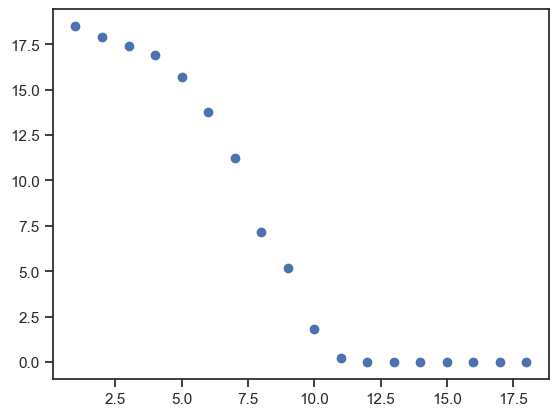

In [55]:
plt.scatter(glucose_df.index, glucose_df['Glucose mean'])

In [56]:
glucose_df

,Time,Glucose mean,Glucose std
0,0,NaN,NaN
1,1,18.5050,24.748737
2,2,17.8950,17.677670
3,3,17.3950,9.192388
4,4,16.9000,21.213203
5,5,15.7000,43.840620
6,6,13.7500,8.768124
7,7,11.2340,5.939697
8,8,7.1560,2.262742
9,9,5.1680,NaN


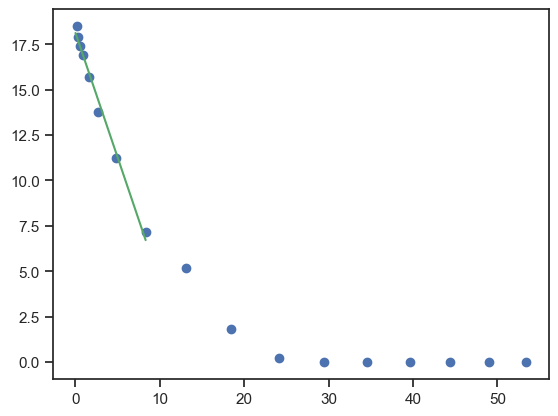

In [57]:
n = 8
fit, cov, _,_,_ = scipy.optimize.curve_fit(fun, x[1:n+1], glucose_df['Glucose mean'][1:n+1], full_output=True)
rate = fit[0]
std_err = np.sqrt(np.diag(cov))[0]
t_score = fit[0]/std_err
n_df = np.sum(idx)-2
p_val = scipy.stats.t.sf(t_score, df = n_df)*2 # *2 is to get two-sided
data = [rate, std_err, t_score, n_df, p_val, c, p_val < 0.05]
x_fit = np.linspace(0, x[n], 3)
y_fit = fun(x_fit, *fit)
plt.plot(x_fit, y_fit, c = 'C2')
plt.scatter(x, glucose_df['Glucose mean'][:-1])


In [58]:
glc_mw = 180.156
glc_uptake = fit[0]/glc_mw*1e3 # Converting from g/gDW/h to mmol/gDW/h
print(glc_uptake)
print(np.sqrt(cov[0][0]))

-7.615874765888068
0.06475661811908084


# Get model

In [59]:
model_ez = reframed.load_cbmodel('../../models/e_coli/momentiJO1366.xml')
model_ez.solver = 'gurobi'

In [60]:
solution = reframed.FBA(model_ez, constraints={'R_EX_glc__D_e': (glc_uptake,0)})

Set parameter Username
Academic license - for non-commercial use only - expires 2024-12-19


In [61]:
solution.show_values('EX')

R_EX_ca2_e   -0.0033875
R_EX_cl_e    -0.0033875
R_EX_co2_e    18.9803
R_EX_cobalt2_e -1.62704e-05
R_EX_cu2_e   -0.000461429
R_EX_fe2_e   -0.0104528
R_EX_glc__D_e -7.61587
R_EX_h_e      5.97986
R_EX_h2o_e    36.1682
R_EX_k_e     -0.127035
R_EX_meoh_e   1.30163e-06
R_EX_mg2_e   -0.00564584
R_EX_mn2_e   -0.000449715
R_EX_mobd_e  -8.39554e-05
R_EX_nh4_e   -7.02936
R_EX_ni2_e   -0.000210214
R_EX_o2_e    -17.5915
R_EX_pi_e    -0.627799
R_EX_so4_e   -0.164143
R_EX_zn2_e   -0.000221929
R_HEX1        7.61587


In [62]:
measured_metabolites = []
for bigg_id in met_abrv_to_id.values():
    if not isinstance(bigg_id, str):
        continue
    m_ids = bigg_id.split(', ')
    for m_id in m_ids:
        if f'M_{m_id}_c' in model_ez.metabolites:
            measured_metabolites.append(f'M_{m_id}_c')

# Reaction knockouts. This might marginally improve model predictions, but for now I keep them out

In [63]:
### Note to acald and THRA
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC277611/
# Glycine is supposedly made from serine in E. coli

# Another paper indicating the glycine is made from glycine, not threonine  https://microbialcellfactories.biomedcentral.com/articles/10.1186/s12934-020-01323-2

# Summary of threonine aldolase here:
# https://biocyc.org/gene?orgid=ECOLI&id=LTAA-MONOMER

In [64]:
# WHY?
#From https://www.sciencedirect.com/science/article/pii/S2405471216302903?via%3Dihub :
# The reactions F6PA and DHAPT are known to be utilized during growth on glycerol but are not active in growth on glucose (Gutknecht et al., 2001).
# r = model_ez.reactions['R_F6PA_TG_forward']
# r.set_flux_bounds(0,0)


# Shadow prices

In [39]:
shadow_prices = leakage_reframed.estimate_shadow_prices(model_ez, constraints={'R_EX_glc__D_e': (glc_uptake,0)}, metabolites = measured_metabolites)

### Adress uncertainty in shadow price estimates
Use uptake rate +- 20%. This is somewhat arbitrary,but is a very conservative estimate that covers different "steps" on the ladder of reduced metabolite value

In [40]:
glc_uptake_range = np.linspace(glc_uptake*1.2, glc_uptake*0.8, 5, endpoint=True)
shadow_price_list = []
for g in glc_uptake_range:
    shadow_prices_i = leakage_reframed.estimate_shadow_prices(model_ez, constraints={'R_EX_glc__D_e': (g,0)}, metabolites = measured_metabolites)
    shadow_price_list.append(shadow_prices_i)

In [41]:
shadow_price_list.append(shadow_prices)

In [42]:
df_sp_var = pd.DataFrame(shadow_price_list)

# Turnover

In [83]:
solution = reframed.pFBA(model_ez, constraints={'R_EX_glc__D_e': (glc_uptake,0)})
# turnover = solution.get_metabolites_turnover(model_ez)

    

In [86]:
# model_ez.get_objective()
# model_ez.reactions['R_BIOMASS_Ec_iJO1366_core_53p95M']

In [91]:
# The turnover of fdp is 0 because the model predicts that F6PA is used instead of FBA . Unlikely, e.g. https://bmcsystbiol.biomedcentral.com/articles/10.1186/1752-0509-7-33

solution.show_metabolite_balance('M_ala__L_c', model_ez)

[ --> o ] R_ICYSDS      0.000462731
[ --> o ] R_SCYSDS      0.000711994
[ --> o ] R_ALATA_L_TG_reverse  0.653758 
[ o --> ] R_BIOMASS_Ec_iJO1366_core_53p95M -0.334318 
[ o --> ] R_AOXSr2     -1.30163e-06
[ o --> ] R_UAMAS      -0.0180849
[ o --> ] R_ALAR_TG_forward -0.0271274
[ o --> ] R_VPAMTr_TG_forward -0.275401 


In [50]:
df_sp_var.max()


M_g6p_c       -0.018786
M_f6p_c       -0.018883
M_fdp_c       -0.026197
M_dhap_c      -0.014344
M_g3p_c       -0.014348
M_2pg_c       -0.009146
M_3pg_c       -0.009019
M_pep_c       -0.010426
M_r5p_c       -0.016494
M_ru5p__D_c   -0.015974
M_ru5p__L_c   -0.018559
M_xu5p__D_c   -0.016006
M_xu5p__L_c         NaN
M_e4p_c       -0.014041
M_cit_c       -0.017530
M_acon_C_c    -0.018491
M_icit_c      -0.019452
M_succ_c      -0.012940
M_oaa_c       -0.011931
M_glu__L_c    -0.019837
M_ser__L_c    -0.050916
M_asp__L_c    -0.015623
M_thr__L_c    -0.043696
M_hom__L_c    -0.033993
M_tyr__L_c    -0.058082
M_gly_c       -0.040909
M_pro__L_c    -0.032088
M_ala__L_c    -0.009140
M_met__L_c    -0.188963
M_val__L_c    -0.085715
M_leu__L_c    -0.137014
M_ile__L_c    -0.098313
M_phe__L_c    -0.057663
M_trp__L_c    -0.202368
M_his__L_c    -0.123813
M_arg__L_c    -0.111554
M_pyr_c       -0.003938
M_orot_c      -0.022706
M_fum_c       -0.013189
M_ura_c       -0.052387
M_akg_c       -0.016433
M_ac_c        -0

# Make spreadsheet

In [46]:
data = []
drop_mets = ['ru5p__L','xu5p__L'] # The L-forms is used in the pentose phosphate pathway, so we assume that it is primarily the D-forms
# 'Std.Err [mmol/gDW/h]', 'T-score', 'degrees of freedom', 'p-val', 'Metabolite abbrv.', 'Significance']
for _, row in rate_data.iterrows():
    if row['R2']<0.5:
        continue
    abbr = row['Metabolite abbrv.']
    rate = row['Rate [mmol/gDW/h]']
    bigg_ids = [x.strip() for x in met_abrv_to_id[abbr].split(',') if not x.strip() in drop_mets]
    if len(bigg_ids)>1:
        print(bigg_ids)
    rate_i = rate/len(bigg_ids)
    std_err_i = row['Std.Err [mmol/gDW/h]']/np.sqrt(len(bigg_ids))
    for bigg_id in bigg_ids:
        name =met_abrv_to_name[abbr]
        m_id = f'M_{bigg_id}_c'
        mv = -shadow_prices[m_id]
        m = model_ez.metabolites[m_id]
        element_dict = ng_utils.get_element_dict(m)
        Nc = element_dict['C']
        mass = ng_utils.get_mol_weight(m)
        mv_min = -df_sp_var.max()[m_id]
        mv_max = -df_sp_var.min()[m_id]
        
        data.append([abbr, bigg_id, name, mv, mv_min, mv_max, turnover[m_id], Nc, mass, rate_i, std_err_i, row['R2']])
df_rate = pd.DataFrame(data, columns = ['Metabolite abbrv.', 'BiGG ID', 'Metabolite', 
                                        'Metabolite value [gDW/mmol]','MV min', 'MV max', 
                                        'Turnover [mmol/gDW/h]', 'N carbons', 
                                        'Mol weight [g/mol]', 'Rate [mmol/gDW/h]', 'Std.Err [mmol/gDW/h]', 'R2'])

['2pg', '3pg']
['ru5p__D', 'xu5p__D']


In [47]:
df_rate['Species'] = 'E. coli'
df_rate['Carbon source'] = 'Glucose'
df_rate['Dataset'] = 'Paczia-13'

In [48]:
df_rate.to_csv('paczia_13_rates_ecoli_0824.csv')

# Estimate shadow prices without enzyme constraints

In [66]:
model0 = model_ez.copy()

In [71]:
model0.reactions.R_ER_pool_TG_

R_ER_pool_TG_:  --> M_prot_pool [0.0, 0.095]

In [72]:
shadow_prices0 = leakage_reframed.estimate_shadow_prices(model0, constraints={'R_EX_glc__D_e': (glc_uptake,0), 'R_ER_pool_TG_':(0, 1000)}, metabolites = measured_metabolites)

In [73]:
data = []
drop_mets = ['ru5p__L','xu5p__L'] # The L-forms is used in the pentose phosphate pathway, so we assume that it is primarily the D-forms
# 'Std.Err [mmol/gDW/h]', 'T-score', 'degrees of freedom', 'p-val', 'Metabolite abbrv.', 'Significance']
for _, row in rate_data.iterrows():
    if row['R2']<0.5:
        continue
    abbr = row['Metabolite abbrv.']
    rate = row['Rate [mmol/gDW/h]']
    bigg_ids = [x.strip() for x in met_abrv_to_id[abbr].split(',') if not x.strip() in drop_mets]
    if len(bigg_ids)>1:
        print(bigg_ids)
    rate_i = rate/len(bigg_ids)
    std_err_i = row['Std.Err [mmol/gDW/h]']/np.sqrt(len(bigg_ids))
    for bigg_id in bigg_ids:
        name =met_abrv_to_name[abbr]
        m_id = f'M_{bigg_id}_c'
        mv = -shadow_prices0[m_id]
        m = model_ez.metabolites[m_id]
        element_dict = ng_utils.get_element_dict(m)
        Nc = element_dict['C']
        mass = ng_utils.get_mol_weight(m)
        
        data.append([abbr, bigg_id, name, mv, Nc, mass, rate_i, std_err_i, row['R2']])
df_rate0 = pd.DataFrame(data, columns = ['Metabolite abbrv.', 'BiGG ID', 'Metabolite', 
                                        'Metabolite value [gDW/mmol]', 'N carbons', 
                                        'Mol weight [g/mol]', 'Rate [mmol/gDW/h]', 'Std.Err [mmol/gDW/h]', 'R2'])

['2pg', '3pg']
['ru5p__D', 'xu5p__D']


In [74]:
df_rate0.to_csv('paczia_13_rates_ecoli_0824_no_enz.csv')